# Databricks Stitch Report

## Intro and Configuration 

**Before We Get Started**

Please wait for stitch to finish before running this report!

**Summary**

This report provides a detailed comparison of customer identity records **before and after running Identity Resolution service**. this notebook is designed to help you understand how your records were consolidated, how connections were established across systems, and how probabilistic matching augmented your identity graph. The goal is to surface how Stitch reshaped your view of unique customer profiles — increasing linkage depth, cross-source visibility, and overall profile completeness.

## Configuration

This Notebook consists of 3 Identity Resolution Reports. 
1. **Identity Resolution Global View** - analyzing how Identity Resolution impacted the global view of customer records.
2. **Identity Resolution by Source** - output breaks down the number of records vs. the number of clusters by input source.
3. **Identity Resolution (Overlap) Across Sources** - reports on how Stitch has associated your customer records into clusters **across sources**. 

These reports are designed to be automated. Cells requiring user input are highlighted below; once these are updated, you will be able to run the report.

**User Inputs**

There are 3 cells below that are configurable. Please review the following before you `Run all` in the notebook.

**Cell 4: Set Path and Optionally Edit Source Semantic Mapping**

1. Confirm that the unified_coalesced_path is correct.

2. (Optional) Update the source semantic mapping. This will make the outputs in the reports more user friendly, but is not required. To edit this change the text after the `:` in Cell 4.

Example: `"original_source_name": "_desired_name_"`

**Cell 5: (Optional) Set PII Classification Levels**

**Note:** The configurations are currently set to defaults and do not require modification. However, these settings are adjustable, and altering them will affect subsequent outputs. **Importantly, the notebook will execute successfully without changing these settings.**

1. **PII sensitivity weighting**: This defines the relative importance or sensitivity of each personally identifiable information (PII) attribute. Higher values indicate attributes that contribute more toward identifying an individual.

2. **PII Classification Levels**: These thresholds define how much PII is needed to categorize a customer into different identity levels, ranging from anonymous to fully known.

**Cell 42: (Optional) Venn Diagram of Overlap**

**Note:** This is one of the more advanced outputs we provide, giving you a visual representation of the overlap between three sources. By default, the output showcases the top three sources, however, you have the option to manually adjust this in the cell if you wish to explore overlaps with additional sources.

**When you are ready, click: Run All!**

Once you ave verified the above inputs, click `Run all` and review your reports!

In [0]:
# 1. Unified Coalesced Path

# User Confirm this is correct #
unified_coalesced_path = "{UNIFIED_PATH}"


# 2. Source Semantic Mapping (Optional)
# This can be really helpful to help land the "what are we actually doing to your data question"
# What this does is replace all the outputs with a semantic mapping of sources you have chosen to provide this for.
# If this is not updated the default source name will be used.
# If you do not want to semantically map your sources leave this unchanged
# If you created this notebook from the Chuck CLI it should have automatically populated this with the values of the datasource field in the stitch results. If not, here is an example of valid mappings:
# {
#    "catalog.schema.input_table_1": "Friendly Name 1",
#    "catalog.schema.input_table_2": "Second Friendly Name",
#    "catalog.schema.input_table_3" : "Third Friendly Name"
# }

# (Optional) USER EDIT HERE #
source_semantic_mapping = {SOURCE_NAMES}

# Turn source_semantic_mapping into a df to join on later.
source_semantic_mapping_df = spark.createDataFrame(
    [(k, v) for k, v in source_semantic_mapping.items()],
    ["source", "source_mapping"]
)
source_semantic_mapping_df.createOrReplaceTempView("source_semantic_mapping_sql")

In [0]:
# 1. PII Sensitivity Weighting
# Assign a score to each PII type, used to calculate the PII classification level.

# USER EDIT HERE (Optional) #
pii_weighting = {
    "given_name": 0.5,
    "surname": 0.5,
    "email": 1.5,
    "phone": 1.5,
    "address": 1,
    "birthdate": 1
}

# 2. PII Classification Levels
# Assign anonymous, partial and known cluster PII score thresholds
# If the score is equal to or greater than, that will be the "known" categorization
# Note to leave the base threshold at 0 or else some records might not have a classification

# USER EDIT HERE (Optional) #
pii_threshold = {
    "0. unknown": 0,
    "1. anonymous": 1.5,
    "2. partial": 2.5,
    "3. known": 3.5
}

### Create Functions To Power Dynamic SQL

In [0]:
# A function to build the SQL formula for PII score based on the weighted PII scores from the input

def build_pii_score_new_sql(pii_scoring, score_column_name="row_pii_score"):
    """
    Builds a SQL formula to calculate PII score.
    Inputs:
        column_mapping: pii_type → actual_column_name
        pii_scoring: pii_type → weight
    Returns:
        SQL CASE-based expression: (CASE WHEN col IS NOT NULL THEN weight ...) AS row_pii_score
    """
    clauses = []

    for col_name, weight in pii_scoring.items():
        clauses.append(f"CASE WHEN {col_name} IS NOT NULL THEN {weight} ELSE 0 END")

    if not clauses:
        return f"0 AS {score_column_name}"

    full_expr = " +\n  ".join(clauses)
    return f"(\n  {full_expr}\n) AS {score_column_name}"

In [0]:
# This function creates case statements based on the PII thresholds entered in step 1.

def build_case_from_thresholds(score_column, column_name, thresholds):
    # Sort from highest to lowest to catch top thresholds first
    sorted_thresholds = sorted(thresholds.items(), key=lambda x: x[1], reverse=True)
    case_lines = [f"WHEN {score_column} >= {v} THEN '{k}'" for k, v in sorted_thresholds]
    #return f"CASE\n  " + "\n  ".join(case_lines) + "\nEND As " + column_name
    return f"CASE\n  {chr(10).join(case_lines)}\nEND AS {column_name}"

sql_expr = build_case_from_thresholds("pii_score", "column_name", pii_threshold)

### Data assets to power visuals
In this section, we create the data assets required to conduct PII completeness analysis using the inputs from section 1."

In [0]:
# In this step, create a view of unified coalesced (this is the raw table with all row level PII as well as the mapped cluster from ID res)
# Note that we left join the source semantic mapping here so that if it exists the mapping will be updated here.

sql_template = """
SELECT Amperity_ID
         , coalesce(source_mapping.source_mapping, uc.datasource) as source
         , given_name, surname, email, phone, address, birthdate

FROM {unified_coalesced} as uc
Left Join source_semantic_mapping_sql as source_mapping
on uc.datasource = source_mapping.source
"""

sql_query = sql_template.format(unified_coalesced=unified_coalesced_path)
spark.sql(sql_query).createOrReplaceTempView("unified_coalesced_sql")

In [0]:
record_level_pii_score_expr = build_pii_score_new_sql(pii_weighting, "record_pii_score")

sql_template = f"""
SELECT *,
  {record_level_pii_score_expr}

FROM unified_coalesced_sql
"""

spark.sql(sql_template).createOrReplaceTempView("pii_query")

In [0]:
source_level_pii_score = build_pii_score_new_sql(pii_weighting, "source_pii_score")
cluster_level_pii_score = build_pii_score_new_sql(pii_weighting, "cluster_pii_score")

sql_template = f"""

-- 1. Get the PII score at the source level (combine PII for every record in the cluster for each source)
With Cluster_and_Source_Aggregate as (
  Select Amperity_ID, Source
         , max(given_name) as given_name, max(surname) as surname, max(email) as email, max(phone) as phone, max(address) as address, max(birthdate) as birthdate
  from pii_query
  Group by 1, 2
)
, cluster_and_source_score as (
  Select Amperity_ID, Source, {source_level_pii_score}
  From Cluster_and_Source_Aggregate
)
-- 2. Get the PII score at the Amp (global) level
, cluster_aggregate as (
  Select Amperity_ID
         , max(given_name) as given_name, max(surname) as surname, max(email) as email, max(phone) as phone, max(address) as address, max(birthdate) as birthdate
         , max(record_pii_score) as max_record_pii_score
  from pii_query
  Group by 1
)
, cluster_score as (
  Select Amperity_ID, max_record_pii_score, {cluster_level_pii_score}
  From cluster_aggregate
)
, final_cte as (
  -- Create a final output at the row level to understand which 
  Select p.record_pii_score, cass.source_pii_score, cs.cluster_pii_score, max_record_pii_score, p.*
  from pii_query as p
  join cluster_and_source_Score as cass
  on p.amperity_ID = cass.amperity_ID and p.source = cass.source
  Join cluster_score as cs
  on p.amperity_id = cs.amperity_ID
  Where 1=1
  order by 5
)
Select * From final_cte order by amperity_ID
"""
#print(sql_template)
spark.sql(sql_template).createOrReplaceTempView("pii_query_sql")

In [0]:
# First generate the 3 levels of "known unknown"
row_pii_known = build_case_from_thresholds("record_pii_score", "row_known_unknown", pii_threshold)
source_pii_known = build_case_from_thresholds("source_pii_score", "source_known_unknown", pii_threshold)
cluster_pii_known = build_case_from_thresholds("cluster_pii_score", "amp_known_unknown", pii_threshold)
max_record_pii_known = build_case_from_thresholds("max_record_pii_score", "max_record_known_unknown", pii_threshold)

final_query = f"""
    Select Amperity_ID, Source
           , record_pii_score
           , {row_pii_known}
           , source_pii_score
           , {source_pii_known}
           , cluster_pii_score
           , {cluster_pii_known}
           , max_record_pii_score
           , {max_record_pii_known}
    From pii_query_sql
"""

#print(final_query)
spark.sql(final_query).createOrReplaceTempView("final_View2_sql")

## VOI Report 1: ID-Res Global View
The below reports show how Identity Resolution with Stitch impacts the global view of customer records.

**Source Records vs Stitched Clusters**

The below results show the comparison between the number of records pre-identity resolution and the number of clusters (unified profiles) post-identity resolution.

In [0]:
%sql
Select count(*) as source_ids, count(distinct Amperity_ID) as amp_ids
From unified_coalesced_sql

Databricks visualization. Run in Databricks to view.

source_ids,amp_ids
139228651,79708992


**Global De-Dupe Rate**

The following output calculates the decrease in clusters compared to the original number of records. This metric is referred to as the de-duplication rate.

Here we calculate the global de-dupe rate as:

`1 - (Clusters post-ID res / Records pre-ID res)
`


In [0]:
%sql
Select count(*) as record_cnt
         , count(distinct Amperity_ID) as cluster_cnt
         , 1 - 1.0 * count(distinct Amperity_ID) / count(*) as de_dupe_rate
  From unified_coalesced_sql

record_cnt,cluster_cnt,de_dupe_rate
139228651,79708992,0.427495767376213


**Improvement in PII Classification**

The below result illustrates the enhancement in PII classification for records due to Identity Resolution, where each cluster is more clearly identified and contains additional PII. 

Identity Resolution improves PII classification by recognizing, organizing, and defining PII elements associated with individual identities across a cluster to achieve a more comprehensive and well-classified understanding of the customer.

_These thresholds can be adjusted above in Cell 5._

In [0]:
%sql
Select coalesce(row_known_unknown, amp_known_unknown) as pii_classification
       , format_number(before_cnt, 0) as pre_id_res_record_cnt
       , format_number(after_cnt, 0) as post_id_res_record_cnt
       , concat(round(before_cnt * 100.0 / SUM(before_cnt) OVER (), 1), '%') AS Perc_pre_ID_Res
       , concat(round(after_cnt * 100.0 / SUM(after_cnt) OVER (), 1), '%') AS perc_post_id_res
       , round(before_cnt * 100.0 / SUM(before_cnt) OVER (), 1) as Perc_pre_ID_Res_old
       , round(after_cnt * 100.0 / SUM(before_cnt) OVER (), 1) as perc_post_id_res_old
       , before_cnt
       , after_cnt
From (Select row_known_unknown, Count(*) as before_cnt from final_View2_sql Group by 1) as before
Full Join (Select amp_known_unknown, Count(*) as after_cnt from final_View2_sql Group by 1) as after
on before.row_known_unknown = after.amp_known_unknown
order by 1

Databricks visualization. Run in Databricks to view.

pii_classification,pre_id_res_record_cnt,post_id_res_record_cnt,Perc_pre_ID_Res,perc_post_id_res,Perc_pre_ID_Res_old,perc_post_id_res_old,before_cnt,after_cnt
0. unknown,"68,322","68,322",0.0%,0.0%,0.0,0.0,68322,68322
1. anonymous,"7,126,300","6,282",5.1%,0.0%,5.1,0.0,7126300,6282
2. partial,"41,667,318","23,408,769",29.9%,16.8%,29.9,16.8,41667318,23408769
3. known,"90,366,711","115,745,278",64.9%,83.1%,64.9,83.1,90366711,115745278


**Shift in PII Classification**

In the following output we expand on the previous output by focusing on the **improvement** of your records.

**On the left** (y axis) we have the pre-Identity Resolution PII classification for every records.

**On the top**(x axis) we have the post-Identity Resolution PII classification.

To read this think of the counts of pre vs post. 
_For example: Row `0. Unknown` --> Column `3. Known` is the count of records that went from being unknown to fully known._

In [0]:
%sql

Select row_known_unknown as pre_id_res_pii_classification
       , amp_known_unknown as post_id_res_pii_classification
       , count(*) as record_cnt
From final_View2_sql
Group by 1, 2
order by 1, 2

Databricks visualization. Run in Databricks to view.

pre_id_res_pii_classification,post_id_res_pii_classification,record_cnt
0. unknown,0. unknown,68322
1. anonymous,1. anonymous,6282
1. anonymous,2. partial,6387327
1. anonymous,3. known,732691
2. partial,2. partial,17021442
2. partial,3. known,24645876
3. known,3. known,90366711


## VOI Report 2: ID-Res By Source

**Records by Source**

This output shows a comparison between the number of records (pre-Identity Resolution) to the number of clusters (post-Identity Resolution) by input source.

In [0]:
%sql
Select source
            , count(*) as source_ids
            , count(distinct Amperity_ID) as amp_ids
  From unified_coalesced_sql
  Group by 1
  order by 2 desc

Databricks visualization. Run in Databricks to view.

source,source_ids,amp_ids
amperity_marketplace.bronze.wifi_connections,41735640,39502598
amperity_marketplace.bronze.e_commerce_customers,34962751,31894240
amperity_marketplace.bronze.pos_customers,32711798,30875076
amperity_marketplace.bronze.loyalty_members,22692162,22458462
amperity_marketplace.bronze.web_visitors,7126300,6640261


**Dedupe Rate By Source**

We then use that analysis to create a de-dupe rate by source. this This highlights sources that are "consolidated, revealing instances where two or more records are merged into a single cluster within the same source. 

This consolidation indicates areas where data can be effectively cleaned and deduplicated, reducing redundancy and presenting a clearer view of customer information for improved decision-making and personalized interactions.



In [0]:
%sql
Select source
            , count(*) as source_ids
            , count(distinct Amperity_ID) as amp_ids
            , round(1 - (1.0 * count(distinct(Amperity_ID)) / count(*)), 3) as source_dupe_rate
            , CONCAT(round(100 - (100.0 * count(distinct(Amperity_ID)) / count(*)), 1), '%') AS source_dedupe_rate_perc
            , count(*) - count(distinct Amperity_ID) as records_de_duped
  From unified_coalesced_sql
  Group by 1
  order by 2 desc

Databricks visualization. Run in Databricks to view.

source,source_ids,amp_ids,source_dupe_rate,source_dedupe_rate_perc,records_de_duped
amperity_marketplace.bronze.wifi_connections,41735640,39502598,0.054,5.4%,2233042
amperity_marketplace.bronze.e_commerce_customers,34962751,31894240,0.088,8.8%,3068511
amperity_marketplace.bronze.pos_customers,32711798,30875076,0.056,5.6%,1836722
amperity_marketplace.bronze.loyalty_members,22692162,22458462,0.010,1.0%,233700
amperity_marketplace.bronze.web_visitors,7126300,6640261,0.068,6.8%,486039


**How Are Clusters Consolidating Records By Source**

Next, we'll explore even deeper into the consolidation of records into clusters. This analysis focuses on instances where clusters are combining 3 or more records into 1, highlighting sources with higher levels of overlapping customer data compared to others.




In [0]:
%sql
With cnts_by_source as (
    Select Amperity_ID, source
                , count(*) as records_in_source_cluster
                , case when count(*) = 1 then '1 Record to 1 Cluster'
                      when count(*) = 2 then '2 Records to 1 Cluster'
                      else '3+ Records to 1 Cluster' 
                end as records_in_cluster
    From unified_coalesced_sql
    Group by 1, 2
  )
Select Source, records_in_cluster, count(*) as cnt
From cnts_by_source
Group by 1, 2
Order by 1, 2

Databricks visualization. Run in Databricks to view.

Source,records_in_cluster,cnt
amperity_marketplace.bronze.e_commerce_customers,1 Record to 1 Cluster,29701219
amperity_marketplace.bronze.e_commerce_customers,2 Records to 1 Cluster,2021803
amperity_marketplace.bronze.e_commerce_customers,3+ Records to 1 Cluster,171218
amperity_marketplace.bronze.loyalty_members,1 Record to 1 Cluster,22295890
amperity_marketplace.bronze.loyalty_members,2 Records to 1 Cluster,128818
amperity_marketplace.bronze.loyalty_members,3+ Records to 1 Cluster,33754
amperity_marketplace.bronze.pos_customers,1 Record to 1 Cluster,29182141
amperity_marketplace.bronze.pos_customers,2 Records to 1 Cluster,1622579
amperity_marketplace.bronze.pos_customers,3+ Records to 1 Cluster,70356
amperity_marketplace.bronze.web_visitors,1 Record to 1 Cluster,6170570


**PII Improvement by Source**

The following output is a table output of the improvement in PII classification by source.

_Accurate PII classification enables better data-driven decision-making based on reliable customer insights and ultimately contributes to improved brand reputation and customer loyalty. Improved PII classification also enables brands to create high-quality data for advanced ML/AI algorithms, enhancing data analysis, predictive modeling, and personalized recommendations._

In [0]:
%sql
-- First group by the Amp_ID + source to not double count Amp_IDs with 2+ records in a source.
With source_grouping as (
  Select source, amperity_ID
         , Source_PII_Score, source_known_unknown
         , cluster_PII_Score, amp_known_unknown
  From final_View2_sql as fv
  Group by 1, 2, 3, 4, 5, 6
)

Select coalesce(before.source, after.source) as source
       , coalesce(row_known_unknown, amp_known_unknown) as pii_known_unknown
       , format_number(before_cnt, 0) as before_cnt
       , format_number(after_cnt, 0) as after_cnt 
       , concat(round(before_cnt * 100.0 / SUM(before_cnt) OVER (partition by before.source), 1), '%') AS percent_of_before
       , concat(round(after_cnt * 100.0 / SUM(after_cnt) OVER (Partition by after.source), 1), '%') AS percent_of_after
From (Select source, row_known_unknown, Count(*) as before_cnt from final_View2_sql Group by 1, 2) as before
Full Join (Select source, amp_known_unknown, Count(*) as after_cnt from final_View2_sql Group by 1, 2) as after
on before.row_known_unknown = after.amp_known_unknown
and before.source = after.source
order by 1, 2

source,pii_known_unknown,before_cnt,after_cnt,percent_of_before,percent_of_after
amperity_marketplace.bronze.e_commerce_customers,3. known,"34,962,751","34,962,751",100.0%,100.0%
amperity_marketplace.bronze.loyalty_members,3. known,"22,692,162","22,692,162",100.0%,100.0%
amperity_marketplace.bronze.pos_customers,3. known,"32,711,798","32,711,798",100.0%,100.0%
amperity_marketplace.bronze.web_visitors,1. anonymous,"7,126,300","6,282",100.0%,0.1%
amperity_marketplace.bronze.web_visitors,2. partial,null,"6,387,327",null,89.6%
amperity_marketplace.bronze.web_visitors,3. known,null,"732,691",null,10.3%
amperity_marketplace.bronze.wifi_connections,0. unknown,"68,322","68,322",0.2%,0.2%
amperity_marketplace.bronze.wifi_connections,2. partial,"41,667,318","17,021,442",99.8%,40.8%
amperity_marketplace.bronze.wifi_connections,3. known,null,"24,645,876",null,59.1%


## VOI Report 3: ID-Res (Overlap) Across Source


Now that we've looked at Identity Resolution within sources, we will next explore how Stitch has associated your records into clusters **across sources**. 

This is especially beneficial when there is no clear join key between two or more sources.

**Overall Cluster vs Record Consolidation**

The first output shows how your overall records are consolidated and brought together through Identity Resolution. 

There are two stacked bar charts that show how once clusters are created, there is an overall reduction in "individuals". 

This is also an easy way to understand how many records were impacted by ID-Resolution.

In [0]:
%sql
With src_cnt as (
  Select 'Source IDs' as source
        , sum(record_cnt) as src_record_count
        , sum(case when record_cnt = 1 then 1 else 0 end) as src_id_1_record
        , sum(case when record_cnt >= 2 then record_cnt else 0 end) as src_id_2plus_records
  From (Select Amperity_ID, count(*) as record_cnt
     From unified_coalesced_sql
     Group by 1
  )
  Group by 1
)
, Amp_ID_Cte as (
  Select 'Clusters' as source, count(*) as cluster_cnt
         , sum(case when record_count = 1 then 1 else 0 end) as cluster_1_record
         , sum(case when record_count >= 2 then 1 else 0 end) as cluster_2plus_records
  From (Select Amperity_ID, count(*) as record_count
        From unified_coalesced_sql
        Group by 1
  )
  Group by 1
)
Select source, '1 Record Clusters' as Resolution_Type, cluster_1_record as value FROM Amp_ID_Cte
Union 
Select source, '2+ Record Clusters' as Resolution_Type, cluster_2plus_records FROM Amp_ID_Cte
Union
Select src_cnt.source, '1 Record to 1 Cluster', src_id_1_record FROM src_cnt
UNION
Select src_cnt.source, '2+ Records to 1 Cluster', src_id_2plus_records FROM src_cnt

Databricks visualization. Run in Databricks to view.

source,Resolution_Type,value
Clusters,1 Record Clusters,47935283
Source IDs,1 Record to 1 Cluster,47935283
Source IDs,2+ Records to 1 Cluster,91293368
Clusters,2+ Record Clusters,31773709


**De-Duper by # of Sources in a Cluster**

In the following output we focus in on understanding how many sources are being brought together by Identity Resolution.

This visuals shows what # of clusters are composed of 1, 2, 3, 4, and 5+ sources.

In [0]:
%sql
 With cte_1 as (
        Select Amperity_ID
                  , count(distinct(source)) as source_count
                  , count(*) as record_count
        From unified_coalesced_sql
        Group by 1
    )
Select --concat(cast(source_count as string), ' Source') as number_of_sources
        case when source_count = 1 then '1 Source'
             when source_count = 2 then '2 Sources'
             when source_count = 3 then '3 Sources'
             when source_count = 4 then '4 Sources'
             when source_count >= 5 then '5+ Sources'
             Else 'Check'
         End as number_of_sources
        , count(*) as amp_ids
        , sum(record_count) as source_count
        , sum(case when record_count > source_count then 1 else 0 end) as intra_source_dupe_count
From cte_1
Group by 1
order by 1

Databricks visualization. Run in Databricks to view.

number_of_sources,amp_ids,source_count,intra_source_dupe_count
1 Source,49961590,52274346,2026307
2 Sources,9675546,20894137,986313
3 Sources,18348691,57294238,1774439
4 Sources,1603943,7450128,425303
5+ Sources,119222,1315802,116889


**Source Overlap**

Next, we want to dive into this concept of source overlap!

First, in cell 41, select 3 sources you'd like to analyze how they overlap. By default, the notebook will choose top 3 sources by record count. 

Next, the venn-diagram in cell 42 will show the overlap of records in those 3 sources.

_Please note, if you select specific sources, please list them in **alphabetical order** for this to run successfully._

In [0]:
%pip install matplotlib matplotlib-venn
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
top_sources_df = spark.sql("""
  With top_3_sources as (
    SELECT source, COUNT(*) as record_count
    FROM unified_coalesced_sql
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 3
  )
  Select source from top_3_sources order by 1
""")

top_sources = [row['source'] for row in top_sources_df.collect()]

# Set the 3 sources to the top 3 sources by record count
source_1, source_2, source_3 = (top_sources + [None, None, None])[:3]


# USER EDIT HERE (Optional) #
# This will overwrite the sources set above
# THESE NEED TO BE IN ALPHABETICAL ORDER #

# source_1 = 'App'
# source_2 = 'NFL Fan View'
# source_3 = 'Oracle CRM'

venn_diagram_groups,cnt
amperity_marketplace.bronze.e_commerce_customers,8853339
"amperity_marketplace.bronze.e_commerce_customers, amperity_marketplace.bronze.pos_customers",441076
"amperity_marketplace.bronze.e_commerce_customers, amperity_marketplace.bronze.pos_customers, amperity_marketplace.bronze.wifi_connections",1751915
"amperity_marketplace.bronze.e_commerce_customers, amperity_marketplace.bronze.wifi_connections",20847910
amperity_marketplace.bronze.pos_customers,28150712
"amperity_marketplace.bronze.pos_customers, amperity_marketplace.bronze.wifi_connections",531373
amperity_marketplace.bronze.wifi_connections,16371400


(8853339, 28150712, 441076, 16371400, 20847910, 531373, 1751915)


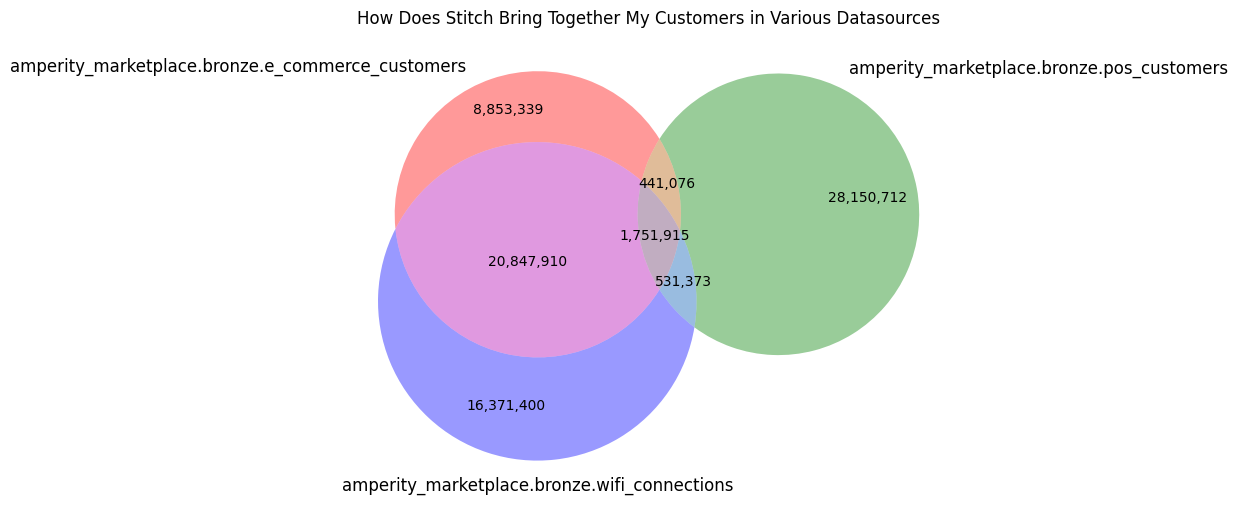

In [0]:
%py 

#Auto generate permutations
s1_2 = ', '.join([source_1, source_2])
s1_3 = ', '.join([source_1, source_3])
s2_3 = ', '.join([source_2, source_3])
s1_2_3 = ', '.join([source_1, source_2, source_3])

sql_source_template = """
    With cte_1 as (
        Select Amperity_ID
                 , source as venn_diagram_source_mapping
        From unified_coalesced_sql as uc
        Where source in ('{source_1}', '{source_2}', '{source_3}')
        Group by 1, 2
        Order by 1, 2
    )
    , cte_2 as (
        Select Amperity_ID
                 , array_join(sort_array(collect_set(venn_diagram_source_mapping)), ', ') AS venn_diagram_groups
        From CTE_1 
        Group by 1
    )
    Select venn_diagram_groups, count(*) as cnt from cte_2 group by 1 order by 1 limit 1000
    --Select * from cte_1 order by 2 limit 100
"""

sql_query = sql_source_template.format(
    source_1=source_1,
    source_2=source_2,
    source_3=source_3
)

spark.sql(sql_query).display()
df_pd = spark.sql(sql_query).toPandas()

group_counts = dict(zip(df_pd['venn_diagram_groups'], df_pd['cnt']))

def get(key):
    return group_counts.get(key, 0)

venn_counts = (
    get(source_1), # A only
    get(source_2),          # B only
    get(s1_2),   # A ∩ B
    get(source_3),          # C only
    get(s1_3),       # A ∩ C
    get(s2_3),       # B ∩ C
    get(s1_2_3)     # A ∩ B ∩ C
)

print(venn_counts)

plt.figure(figsize=(8, 8))

# Create the Venn diagram and capture the object
venn_obj = venn3(subsets=venn_counts, set_labels=(source_1, source_2, source_3))

# Format each label with comma separators
for subset_label in venn_obj.subset_labels:
    if subset_label:  # skip empty/None regions
        val = subset_label.get_text()
        if val and val.isdigit():
            subset_label.set_text(f"{int(val):,}")

plt.title("How Does Stitch Bring Together My Customers in Various Datasources")
plt.show()

**Records Overlap Between Each Combination of Sources**

Lastly, let's review how many records are overlapping for each combination of sources across all sources.

_Please disregard the total calculations row and column as they do not apply to the purpose of this visual._

In [0]:
%sql
-- Write a pivot so when we have app, how often does it have ticketing.

-- First make a CTE of all the permutations of joins.
With amp_and_source_cte as (
  Select Amperity_ID, source
  From unified_coalesced_sql
  Group by 1, 2
)
-- Join the aggregate to itself to get all the permuations of the ways sources join by cluster.
, cte_2 as (
  Select s1.Amperity_ID, s1.source as source_1, s2.source as source_2
  FROM amp_and_source_cte as s1
  Full Join amp_and_source_cte as s2
  on s1.Amperity_ID = s2.Amperity_ID
  --and s1.source <= s2.source
)
Select source_1, source_2, count(*)  as cnt
FROM cte_2
Where 1=1
  And source_1 <> source_2
Group by 1, 2
order by 1, 2


Databricks visualization. Run in Databricks to view.

source_1,source_2,cnt
amperity_marketplace.bronze.e_commerce_customers,amperity_marketplace.bronze.loyalty_members,19593140
amperity_marketplace.bronze.e_commerce_customers,amperity_marketplace.bronze.pos_customers,2192991
amperity_marketplace.bronze.e_commerce_customers,amperity_marketplace.bronze.web_visitors,418183
amperity_marketplace.bronze.e_commerce_customers,amperity_marketplace.bronze.wifi_connections,22599825
amperity_marketplace.bronze.loyalty_members,amperity_marketplace.bronze.e_commerce_customers,19593140
amperity_marketplace.bronze.loyalty_members,amperity_marketplace.bronze.pos_customers,1561157
amperity_marketplace.bronze.loyalty_members,amperity_marketplace.bronze.web_visitors,322036
amperity_marketplace.bronze.loyalty_members,amperity_marketplace.bronze.wifi_connections,19576833
amperity_marketplace.bronze.pos_customers,amperity_marketplace.bronze.e_commerce_customers,2192991
amperity_marketplace.bronze.pos_customers,amperity_marketplace.bronze.loyalty_members,1561157
